In [1]:
from typing import List
import matplotlib.pyplot as plt
from src.repository.surebet_repository import SurebetRepository
from src.repository.game_repository import GameRepository
from src.genetic.arbitrage import CrossOverEnum, Population
from src.util import ExportadorDeGraficos, PickleSerializer
from datetime import datetime, timedelta
game_repository = GameRepository()
repository = SurebetRepository()

<h3> Parâmetros para execução do experimento </h3>

In [2]:
n_generations = 150
n_individuals = 50
mutation_rate = 0.05
crossover_rate = 0.98
crossover=CrossOverEnum.UNIFORM_CROSSOVER

### Método para gerar intervalos entre dois tempos (horas)

In [3]:
def gera_intervalos(start="2023-09-02 14:00:00", end="2023-09-02 15:00:00", freq=5) -> List[str]:
    
    start_time = datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
    
    interval = timedelta(minutes=freq)
    
    current_time = start_time
    intervals = [start]
    while current_time < end_time:
        current_time += interval
        intervals.append(current_time.strftime('%Y-%m-%d %H:%M:%S'))
    
    return intervals

<h3>Métodos auxiliares para plot, consulta ao banco e munipulação dos dados</h3>

In [4]:
def get_teams(ids):
    return game_repository.get_teams(ids)

In [5]:
from src.genetic.arbitrage import Individual

def decode_individual(individual: Individual, population: Population, individual_label, report_header, path, teams_dict: dict, verbose=True):
    profit = individual.fitness[0]
    number_of_surebets_chosen = sum([i[0] for i in individual.chromosome])
    surebets_selected = []
        
    for gene, arbitrage in zip(individual.chromosome, individual.arbitrages):
        if gene[0] == 1:
            surebets_selected.append((f'Game: {teams_dict.get(arbitrage.game_id)}', f'Bookmaker 1: {arbitrage.bookmaker_key_OVER}', f'Bookmaker 2: {arbitrage.bookmaker_key_UNDER}', f'Amount bet R$ {round(gene[1] * population.budget, 2)}', f'Profit R$ {((gene[1]*population.budget)*(arbitrage.profit/100)):,.2f}', f'{arbitrage.profit:,.2f}%'))
    
    if verbose:
        print(individual_label)
        print(f'Number of surebets chosen: {number_of_surebets_chosen}')
        print('Surebets Selected:')
        for i in surebets_selected:
            print(i)
    
        print(f'Total Profit: R$ {profit:,.2f}')
        print('-------------------------------------------------------------------------------------------------------------------------------------------------------')
    
    with open(path, 'a') as file:
        if report_header is not None:
            file.write(report_header)

        file.write(f'{individual_label}\n')
        file.write(f'Number of surebets chosen: {number_of_surebets_chosen}\n')
        file.write('Surebets Selected:\n')
        for i in surebets_selected:
            file.write(str(i)+'\n')
        file.write(f'Total Profit: R$ {profit:,.2f}\n')
        file.write('-------------------------------------------------------------------------------------------------------------------------------------------------------\n')
        
    

### Evolução da fronteira de pareto (3 fronteiras)

In [6]:
def paretos_frontier_evolution_plot(population: Population, export: ExportadorDeGraficos):
    plt.figure()
    plt.title('Evolução da Fronteira de Pareto')
    plt.xlabel('Profit')
    plt.ylabel('Dispersation')
    colors = ['#7634BB', '#2BF063', '#9DC3E6']
    path = export.data_hora_atual + '/' + 'pareto_evolution.png'
    evolution_points = len(population.evolution_front)
    aux = population.evolution_front[0], population.evolution_front[evolution_points//2], population.evolution_front[-1]

    aux = [(h, sorted(f, key=lambda x :x[1])) for h, f in aux]
    count = 0
    for hypervolume, front, in aux:
        x = [i[0] for i in front]
        y = [i[1] for i in front]
        plt.plot(x, y, marker='o', label=f'Hv = {hypervolume:,.4f}')
        plt.scatter(x, y, color=colors[count])
        count += 1
    plt.legend()
    plt.savefig(path)
    plt.close()

def export_pareto_frontier_evolution(population: Population, export: ExportadorDeGraficos):
    evolution_frontier_x = list()
    evolution_frontier_y = list()
    generation_plot = [0, population.n_generations - 1, population.best_frontier-1]
    for generation, front in population.pareto_history_front_normalized:
        x = [i[0] for i in front]
        y = [i[1] for i in front]
        if generation in generation_plot:
            export.plot(x, y, generation+1)
            evolution_frontier_x.append(x)
            evolution_frontier_y.append(y)
    paretos_frontier_evolution_plot(population, export)



### Hypervolume por gerações

In [7]:
def hypervolume_per_generation(population: Population, export: ExportadorDeGraficos):    
    export.hypervolume_plot(population)

### Fronteira de pareto com 3 indivíduos selecionados

In [8]:
def pick_up_individuals(front):   
    front_fitness = list({tuple(i.fitness) for i in front})  # Remove os itens repetidos
    OPTIMIZE_PROFIT = -1
    OPTIMIZE_MIDDLE = ((len(front_fitness) // 2) - 1)
    OPTIMIZE_DISPERSATION = 0
    
    front_sorted = sorted(front, key=lambda x: x.fitness[0])
    front_fitness = sorted(front_fitness, key=lambda x: x[0])
    
    aux_individuals_selected = front_fitness[OPTIMIZE_PROFIT], front_fitness[OPTIMIZE_MIDDLE], front_fitness[OPTIMIZE_DISPERSATION]  # Seleciona os 3 indivíduos (Aqui só tem os fitness)
    selected = []
    
    # Método para descobrir qual a é o indivíduo(dentro da fronteira de pareto que possui vários objetos) que possui o fitness escolhido anteriormente
    for i in aux_individuals_selected:
        for individual in front_sorted:
            if list(i) == individual.fitness:
                selected.append(individual)
                break

    return front_sorted, selected


def normalize(front, high_fitness_evaluated):
    max_profit = high_fitness_evaluated[0]
    max_dispersation = high_fitness_evaluated[1]
    for i in front:
        profit_normalized = i.fitness[0] / max_profit
        dispersation_normalized = i.fitness[1] / max_dispersation
        i.fitness_normalized = [profit_normalized, dispersation_normalized]
        

def paretos_frontier_plot(front, selected_individuals, path):
    plt.figure()
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.title(f'Pareto Front')
    plt.xlabel('Profit')
    plt.ylabel('Dispersation')
    plt.scatter([i.fitness_normalized[0] for i in front], [i.fitness_normalized[1] for i in front])
    plt.scatter([i.fitness_normalized[0] for i in selected_individuals], [i.fitness_normalized[1] for i in selected_individuals], color='#2BF063')
    plt.plot([i.fitness_normalized[0] for i in front], [i.fitness_normalized[1] for i in front], color='red', linewidth=1, linestyle='-')
    plt.savefig(path)
    plt.close()


def plot_3_individuals_selected_front(population: Population, export: ExportadorDeGraficos):
    if population.best_frontier is None:
        export.calculate_hypervolume(population)

    frontier = population.pareto_history_front[population.best_frontier][1]
    
    front_sorted, individuals_selected = pick_up_individuals(frontier)
    
    normalize(front_sorted, population.high_fitness_evaluated)
    normalize(individuals_selected, population.high_fitness_evaluated)
    
    path = export.data_hora_atual + '/' + export.get_file_name(population.best_frontier, 'png')
    paretos_frontier_plot(front_sorted, individuals_selected, path)

    return individuals_selected

### Salva objeto em binário com pickle

In [9]:
def export_pickle(population: Population, export: ExportadorDeGraficos):
    PickleSerializer.save(population, f'{export.data_hora_atual}/pickle.pkl')

### Exporta dados (hypervolume, fronteiras de pareto e binário) 

In [10]:
def run_scenario(start_date = '2023-09-02 14:00:00', end_date = '2023-09-02 14:05:00', verbose=True, count=0):
    export = ExportadorDeGraficos()
    
    arbitrages = repository.find_all_unique_between(start_date, end_date)
    population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
                            budget=1000, crossover_strategy=crossover, arbitrages=arbitrages)
    
    
    # Salvando binário de population
    export_pickle(population, export)
    
    # Gerando hypervolume por geração
    hypervolume_per_generation(population, export)
    
    # Gerando fronteira de pareto com 3 indivíduos selecionados (Melhor lucro, melhor distribuição e intermediário)
    individuals_picked_up = plot_3_individuals_selected_front(population, export)
    
    # Gerando evolução da fronteira de pareto
    export_pareto_frontier_evolution(population, export)
    
    # Pegando os nomes dos times
    teams_dict = get_teams([i.game_id for i in arbitrages])
    
         
    labels = ['Profit Optimization', 'Equilibrium Optimization', 'Dispersation Optimization']
    folder = export.data_hora_atual
    start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
    end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
    date_event = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S').strftime('%d/%m/%Y')
    path = f"{folder}/report_{start}_{end}.txt"

    report_header = f"""************************************************************* EXPERIMENTAL RESULT REPORT *************************************************************

[Date]: {date_event}
[Surebet Interval]: {start} to {end}
[Best frontier]: {population.best_frontier + 1}º generation
[Budget]: R$ {population.budget:,.2f}

"""
    for label, individual in zip(labels, individuals_picked_up):
        decode_individual(individual, population, label, report_header, path, teams_dict, verbose)
        report_header = None


### Gera gráfico lucro acumulado

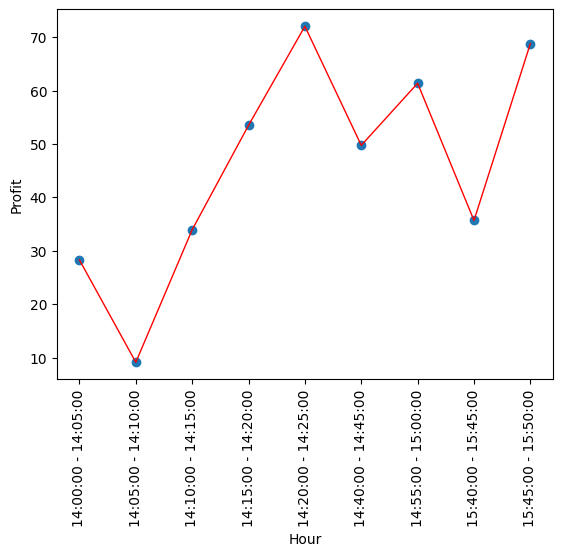

In [17]:
def plot_interval_profit(x, y, title, export: ExportadorDeGraficos):
    plt.figure()
    plt.title(title)
    plt.xlabel('Hour')
    plt.ylabel('Profit')
    plt.xticks(rotation=90)
    plt.scatter(x, y)
    plt.plot(x, y, color='red', linewidth=1, linestyle='-')
    plt.show()
    # plt.savefig(export.data_hora_atual + '/' + export.get_file_name(0, 'png'))
    plt.close()
    
def interval_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 16:00:00'):
    export = ExportadorDeGraficos()
    
    intervals = gera_intervalos(start_date, end_date)
    x_values = []
    y_values = []
    for i in range(len(intervals)-1):
        start = intervals[i] 
        end = intervals[i+1]
        
        arbitrages = repository.find_all_unique_between(start, end)
        if len(arbitrages) > 1:
            population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
                                    budget=1000, crossover_strategy=crossover, arbitrages=arbitrages)
        
            if population.best_frontier is None:
                export.calculate_hypervolume(population)
            
            best_front: List[Individual] = population.pareto_history_front[population.best_frontier][1]
            max_profit = max([i.fitness[0] for i in best_front])
        else:
            continue
            
        x_values.append(f'{datetime.strptime(start, "%Y-%m-%d %H:%M:%S").strftime("%H:%M:%S")} - {datetime.strptime(end, "%Y-%m-%d %H:%M:%S").strftime("%H:%M:%S")}')
        y_values.append(max_profit)
        
    
    plot_interval_profit(x_values, y_values, '', export)
interval_profit()

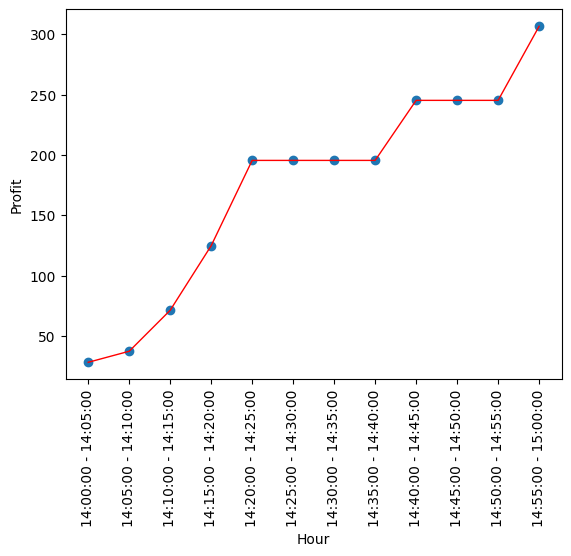

In [19]:
def accumulated_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 15:00:00'):
    export = ExportadorDeGraficos()
    
    intervals = gera_intervalos(start_date, end_date)
    x_values = []
    y_values = [0]
    for i in range(len(intervals)-1):
        start = intervals[i] 
        end = intervals[i+1]
        arbitrages = repository.find_all_unique_between(start, end)

        if len(arbitrages) > 1:
            population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
                                    budget=1000, crossover_strategy=crossover, arbitrages=arbitrages)
    
            if population.best_frontier is None:
                export.calculate_hypervolume(population)
            
            best_front: List[Individual] = population.pareto_history_front[population.best_frontier][1]
            max_profit = max([i.fitness[0] for i in best_front])
        else:
            # max_profit = 0
            continue
            
        x_values.append(f'{datetime.strptime(start, "%Y-%m-%d %H:%M:%S").strftime("%H:%M:%S")} - {datetime.strptime(end, "%Y-%m-%d %H:%M:%S").strftime("%H:%M:%S")}')
        y_values.append(y_values[len(y_values)-1] + max_profit)
            
    plot_interval_profit(x_values, y_values[1:], '', export)
accumulated_profit()

<h3> Cenários mês de setembro </h3>
<img src="images/surebets_setembro.png" width="75%">
<br> <br>
<img src="images/surebets_02_setembro.png" width="75%">

<h3> Cenário 02/09/2023 </h3>

In [13]:
run_scenario(start_date='2023-09-02 14:00:00', end_date='2023-09-02 14:05:00', verbose=False)


### Cenário 24/09/2023
